# ts_aos_analysis

# AOS  DM-46763:  WET-007 Compare CWFS approaches with OR4 ComCam data 

Use OR4 ComCam  data. It is in `embargo_or4` repository.

Find out the range of data :

In [5]:

from lsst.daf import butler as dafButler
butler = dafButler.Butler('embargo_or4')

INFO:botocore.credentials:Found credentials in shared credentials file: /home/s/scichris/.lsst/aws-credentials.ini


In [13]:
#butler.registry.queryCollections()

In [8]:
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults']).expanded()
refs = []
for ref in dataRefs:
    refs.append(ref)

In [9]:
len(refs)

25340

ok, how many of these are actually defocal ? Try this constraint:

In [10]:
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
                                         where= "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'").expanded()
refs = []
for ref in dataRefs:
    refs.append(ref)
   

In [12]:
len(refs)

414

Ok, let's try running these through pipeline to run ISR:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    

    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i LSSTComCamSim/defaults \
    -o u/scichris/or4_night1_isr \
    -p lsstComCamSimPipelineISR.yaml \
    -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"


I get `/sdf/data/rubin/shared/scichris/DM-46763_WET-007/submit/u/scichris/or4_night1_isr/20241018T003228Z`:


                 UNKNOWN MISFIT UNREADY READY PENDING RUNNING DELETED HELD SUCCEEDED FAILED PRUNED EXPECTED
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    TOTAL              0      0       0     0       1       0       0    0       415      0      0      416
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    pipetaskInit       0      0       0     0       0       0       0    0         1      0      0        1
    isr                0      0       0     0       0       0       0    0       414      0      0      414
    finalJob           0      0       0     0       1       0       0    0         0      0      0        1


Check the ISR results:

In [14]:
butler = dafButler.Butler('embargo_or4')
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['u/scichris/or4_night1_isr']).expanded()
refs = []
for ref in dataRefs: 
    refs.append(ref)

In [19]:
refs[0].dataId.detector

detector.RecordClass(instrument='LSSTComCamSim', id=7, full_name='R22_S21', name_in_raft='S21', raft='R22', purpose='SCIENCE')

In [21]:
exp = butler.get('postISRCCD', dataId=refs[0].dataId, collections=['u/scichris/or4_night1_isr'])


Text(0.5, 1.0, 'det 7 ')

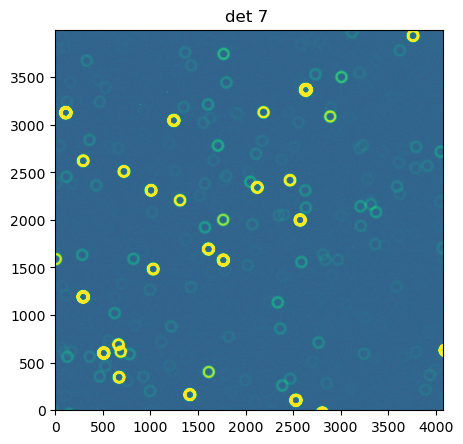

In [23]:
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(5,5))
idx=0

d = exp.image.array
vmin,vmax = zscale.get_limits(d)
ax.imshow(d, vmin=vmin, vmax=vmax, origin='lower')

detId = refs[idx].dataId.detector.id
ax.set_title(f'det {detId} ')


Run donut detection and cutouts:



    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_isr \
    -o u/scichris/or4_night1_direct_stamps \
    -p lsstComCamSimPipelineDirectCutoutOnly.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    
I get 




                                  UNKNOWN MISFIT UNREADY READY PENDING RUNNING DELETED HELD SUCCEEDED FAILED PRUNED EXPECTED
    ----------------------------- ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    TOTAL                               0      0       0     0       0       0       0    0       425      0      0      425
    ----------------------------- ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    pipetaskInit                        0      0       0     0       0       0       0    0         1      0      0        1
    generateDonutDirectDetectTask       0      0       0     0       0       0       0    0       414      0      0      414
    cutOutDonutsScienceSensorTask       0      0       0     0       0       0       0    0         9      0      0        9
    finalJob                            0      0       0     0       0       0       0    0         1      0      0        1


Check that the donut cutouts make sense: 

In [25]:
butler = dafButler.Butler('embargo_or4')
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
           collections=['u/scichris/or4_night1_direct_stamps'],
                                        where=f"instrument='LSSTComCamSim'").expanded()
for ref in dataRefs:
    print(ref)

donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 1, visit: 7024062500128, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=dfe26383-b181-4324-b0dd-e37343b3a6d8)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500071, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=2751a363-8e1f-4916-b842-a82a8d9b178a)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 6, visit: 7024062500068, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=29dd8339-eff9-4ed3-9eba-c8fd859549af)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 6, visit: 7024062500062, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=43c58798-e22e-4a28-83ff-36a079

In [26]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=ref.dataId,
                              collections=['u/scichris/or4_night1_direct_stamps'])

In [27]:
len(donutStampsIntra)

42

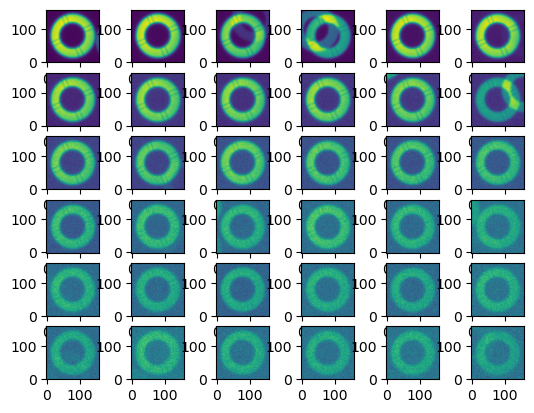

In [31]:
import numpy as np 
fig,axs = plt.subplots(6,6)

ax = np.ravel(axs)

for i  in range(len(ax)):
    stamp = donutStampsIntra[i]
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
if len(donutStampsIntra)<len(ax):
    for i in range(len(donutStampsIntra), len(ax)):
        ax[i].axis('off')
        

There are a lot of donuts as we used `donutSelector.useCustomMagLimit: True` to provide as many donuts as possible.

So now we can run the Danish and TIE; the pipielines contain

    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing
    description: basic processing pipeline with imsim
    
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCamSim
    
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
              config.estimateZernikes.retarget(EstimateZernikesDanishTask)
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
    
    
(`config.estimateZernikes.retarget(EstimateZernikesTieTask)`  for the TIE version )

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma -g 1800 s3df --account rubin:developers
    
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_direct_stamps \
    -o u/scichris/or4_night1_direct_danish \
    -p lsstComCamSimPipelineCalcDanish.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
     
    bps report --id 3284025.0
    
     
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_direct_stamps \
    -o u/scichris/or4_night1_direct_tie \
    -p lsstComCamSimPipelineCalcTie.yaml  \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    
    bps report --id 3284027.0

Analyze the outputs:  is there OPD available? 

In [43]:
butler = dafButler.Butler('embargo_or4')
u/scichris/or4_night1_direct_danish


In [34]:
# find a query that returns all the donuts
len(list(butler.registry.queryDimensionRecords(
    "exposure", 
    where="day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'",
)))

46

In [44]:
butler.registry.queryCollections("*danish*")

['u/crenshaw/or4_night1_danish/20240626T182500Z',
 'u/scichris/or4_night1_direct_danish/20241018T035857Z',
 'u/scichris/or4_night1_direct_danish/20241018T040540Z',
 'u/crenshaw/or4_night1_danish',
 'u/scichris/or4_night1_direct_danish']

In [47]:
butler.ge

TypeError: RegistryShim.queryDatasetTypes() got an unexpected keyword argument 'collections'

In [52]:
for dr in butler.registry.queryDatasets("zernikeEstimateAvg", collections="u/scichris/or4_night1_direct_danish"):
    print(dr)
    break

zernikeEstimateAvg@{instrument: 'LSSTComCamSim', detector: 3, visit: 7024062500119, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=NumpyArray] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=f975fe5d-047b-4a10-94e0-81799775af3f)


In [50]:
butler.getURI(dr)

ResourcePath("s3://embargo@rubin-summit-users/u/scichris/or4_night1_direct_danish/20241018T040540Z/zernikeEstimateRaw/20240625/i/i_06/7024062500104/zernikeEstimateRaw_LSSTComCamSim_i_i_06_7024062500104_R22_S20_u_scichris_or4_night1_direct_danish_20241018T040540Z.pickle")

In [56]:
# Try to find data with zernikes
list(butler.registry.queryDatasets("residualZernikePyramid", collections="u/scichris/or4_night1_direct_danish"))[:10]

[]

Why are there no datasets created by the aggregate tasks?  Try running them interactively... Find out what's going on ... 

In [ ]:
Try running just the aggregation:


REPO=embargo_or4
INPUT_COLLECTION=u/scichris/or4_night1_direct_danish
OUTPUT_COLLECTION=u/scichris/or4_night1_direct_danish_viz
PIPELINE_FILE=/sdf/group/rubin/shared/scichris/DM-46763_WET-007/donut_pipeline.yaml

cat <<EOF > $PIPELINE_FILE
description: Donut pipeline
instrument: lsst.obs.lsst.LsstComCamSim
tasks:
  aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
  aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
  aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
  plotAOSTask: lsst.donut.viz.PlotAOSTask
  aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
  plotDonutTask: lsst.donut.viz.PlotDonutTask
EOF

pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'" --register-dataset-types



Is the collection there ? 

In [57]:
butler =  dafButler.Butler('embargo_or4')

In [66]:
dr = butler.registry.queryDatasets('donutPlot*', collections=['u/scichris/or4_night1_direct_danish_viz'],
                                  where="instrument='LSSTComCamSim' and visit=7024062500074").expanded()
refs = []
for ref in dr:
    print(ref)
    refs.append(ref)

donutPlotExtra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=016b7b6d-695f-4894-9899-180170720c6e)
donutPlotExtra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish_viz/20241018T045049Z id=967b50aa-4880-4d42-8a9a-e2faddb24bce)
donutPlotIntra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=291bfc72-e48d-4e02-8fb6-9815deacc8c7)
donutPlotIntra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish_viz/20241018T045049Z id=e363e9fe-34fd-4672-b1aa-2d87ff334344)


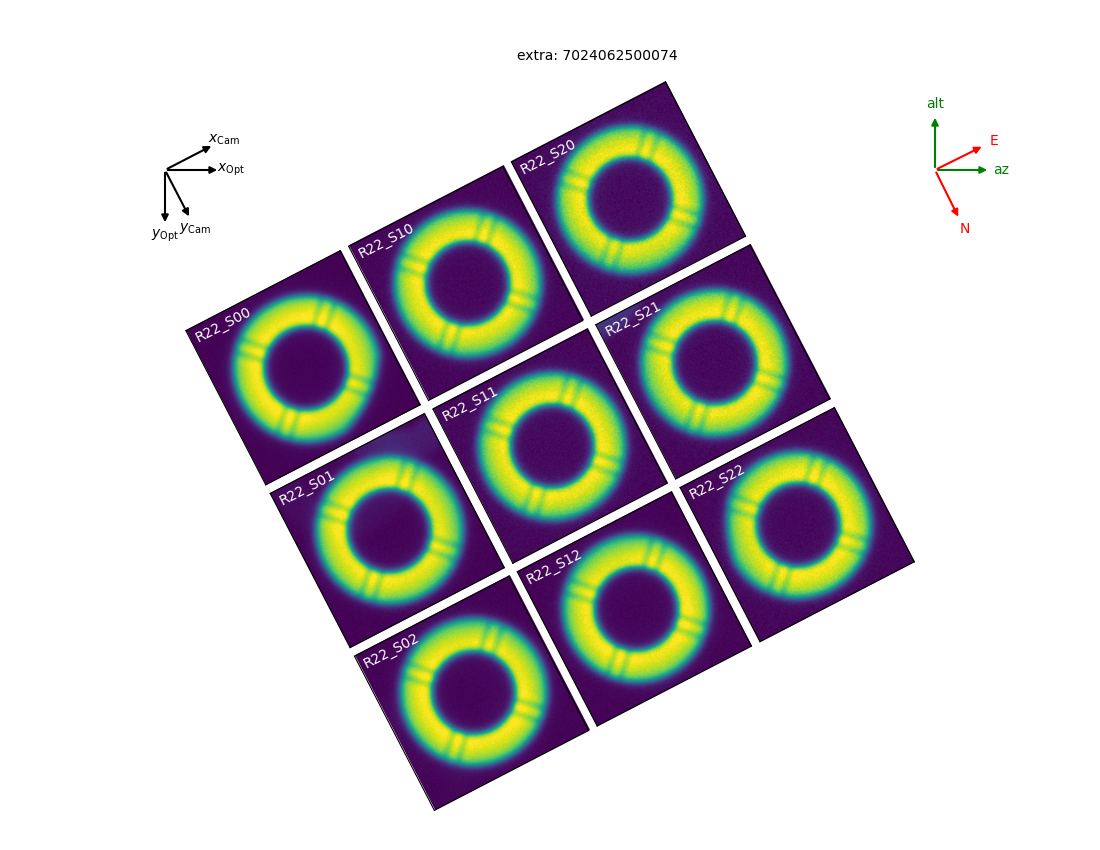

In [69]:
from IPython.display import Image
butler.getURI(refs[1])
Image(butler.getURI(refs[1]).read())

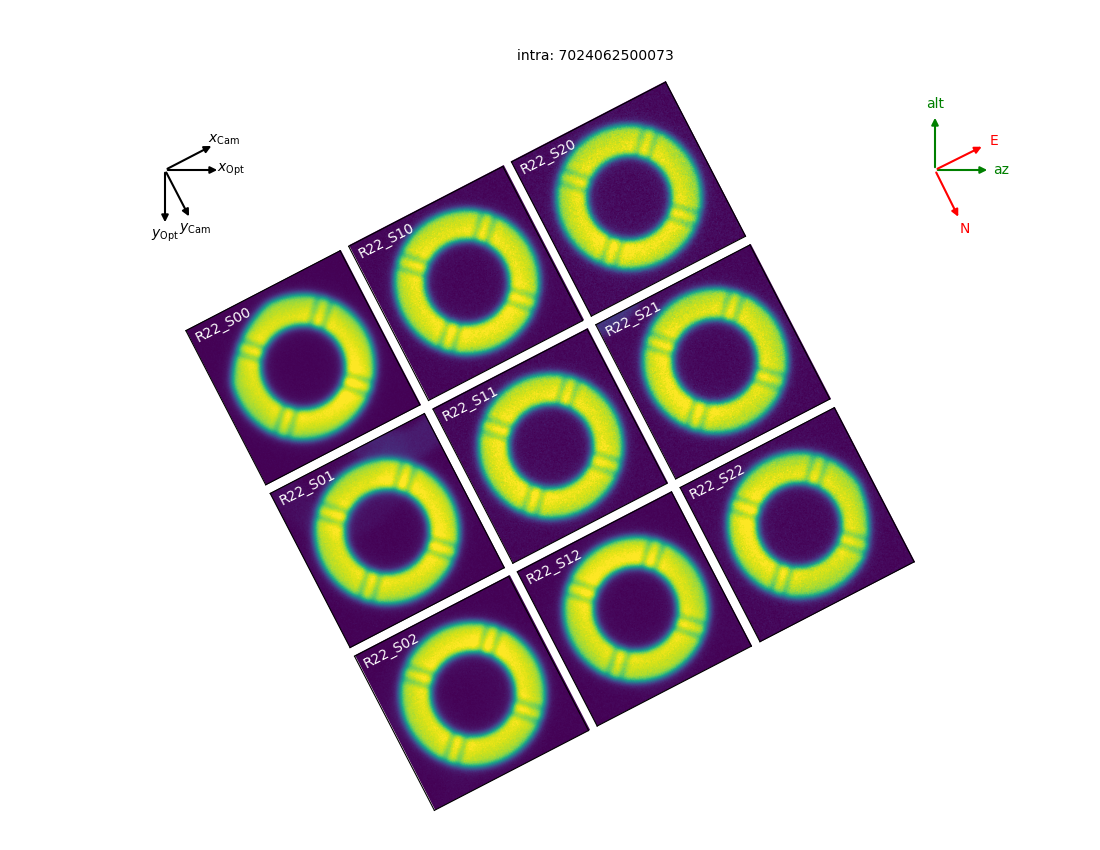

In [70]:
butler.getURI(refs[2])
Image(butler.getURI(refs[2]).read())

In [79]:
list(butler.registry.queryDatasets('residual*', collections=['u/scichris/or4_night1_direct_danish_viz']))



[]

nothing! Why it didn't make any `residualZernikePyramid` at all ?

Plot the Zernike results:

In [81]:
butler = dafButler.Butler('embargo_or4')
collection = 'u/scichris/or4_night1_direct_danish'

dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw',collections=[collection]).expanded()

In [125]:
butler = dafButler.Butler('embargo_or4')
dataRefsMethod={}
for method in ['tie', 'danish']:
    collection = f'u/scichris/or4_night1_direct_{method}'
    dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw',collections=[collection]).expanded()
    dataRefsMethod[method]=dataRefs

In [128]:
len(list(dataRefsMethod['tie']))

207

In [129]:
len(list(dataRefsMethod['danish']))

207

In [130]:
list(dataRefsMethod['tie'])[0]

DatasetRef(DatasetType('zernikeEstimateRaw', {band, instrument, day_obs, detector, physical_filter, visit}, NumpyArray), {instrument: 'LSSTComCamSim', detector: 7, visit: 7024062500083, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}, run='u/scichris/or4_night1_direct_tie/20241018T040647Z', id=4f512c25-7154-4bcc-a871-a55e90a27190)

In [119]:
from astropy.table import Table

detId=[]; detName=[]; visit=[]; day=[]; refId=[]
refs=[]
i=0
for ref in dataRefs:
    #refs.append(ref)
    detId.append(ref.dataId.detector.id)
    detName.append(ref.dataId.detector.full_name)
    visit.append(ref.dataId.visit.id)
    day.append(ref.dataId.day_obs.id)
    refId.append(i)
    i+=1 

table = Table(data=[detId, detName, visit, day,refId], names=['detId', 'detName', 'visit', 'day','refId'])

In [123]:
visits = np.unique(table['visit'].value)

In [124]:
visits

array([7024062500062, 7024062500065, 7024062500068, 7024062500071,
       7024062500074, 7024062500077, 7024062500080, 7024062500083,
       7024062500086, 7024062500089, 7024062500092, 7024062500095,
       7024062500098, 7024062500101, 7024062500104, 7024062500107,
       7024062500110, 7024062500113, 7024062500116, 7024062500119,
       7024062500122, 7024062500125, 7024062500128])

In [131]:
# prepare  the dictionary
results = {}
for method in ['danish','tie']:
    results[method] = {}
    for visit in visits:
        results[method][visit] = {}
        
# let's see if the refs from one collection work for the other given that they have the same content 
for ref in dataRefs:
    detector = ref.dataId.detector.id
    visit = ref.dataId.visit.id
    for method in results.keys():
        collection = f'u/scichris/or4_night1_direct_{method}'
        results[method][visit][detector] = butler.get('zernikeEstimateAvg', dataId=ref.dataId, collections=[collection])


In [133]:
results['danish'][visit][0]

array([[ 1.66617009e-02, -1.38903481e-01, -1.15097898e-02,
         1.27804208e-01,  3.27594469e-01,  3.34479466e-02,
        -2.10533844e-02,  2.26716282e-02,  3.44170137e-03,
         4.18002349e-02, -9.03970715e-03, -8.12936540e-04,
        -1.44236194e-03, -7.87897114e-04,  4.43854487e-04,
        -1.21970355e-03,  1.33972160e-03,  1.57966097e-03,
         1.11982122e-02,  2.98822580e-03,  6.48343969e-04,
        -3.16052951e-04,  8.98347748e-04,  9.03126882e-04,
         5.97918153e-04]])

In [134]:
results['tie'][visit][0]

array([[ 1.25665369e-01, -1.22814461e-01, -1.75376719e-03,
         8.24004525e-02,  2.57328835e-01,  5.15493416e-02,
        -2.49595863e-02,  3.58493254e-02,  1.24441569e-03,
         4.13898254e-02, -2.10658386e-03, -1.07351903e-03,
         6.80476033e-03,  5.02472296e-03,  3.59936777e-03,
        -2.61347330e-03, -4.24925026e-03, -1.64345410e-03,
         9.72954074e-03,  2.55516419e-03,  5.82166318e-04,
         1.84771855e-05,  7.87484507e-04, -1.92180999e-03,
         4.49644634e-03]])

Plot the two methods for all detectors from a single visit: 

In [141]:
results[method][visit][i][0]

array([ 1.66617009e-02, -1.38903481e-01, -1.15097898e-02,  1.27804208e-01,
        3.27594469e-01,  3.34479466e-02, -2.10533844e-02,  2.26716282e-02,
        3.44170137e-03,  4.18002349e-02, -9.03970715e-03, -8.12936540e-04,
       -1.44236194e-03, -7.87897114e-04,  4.43854487e-04, -1.21970355e-03,
        1.33972160e-03,  1.57966097e-03,  1.11982122e-02,  2.98822580e-03,
        6.48343969e-04, -3.16052951e-04,  8.98347748e-04,  9.03126882e-04,
        5.97918153e-04])

In [161]:
#fig.text?

Text(0.05, 0.5, 'Zk value [microns]')

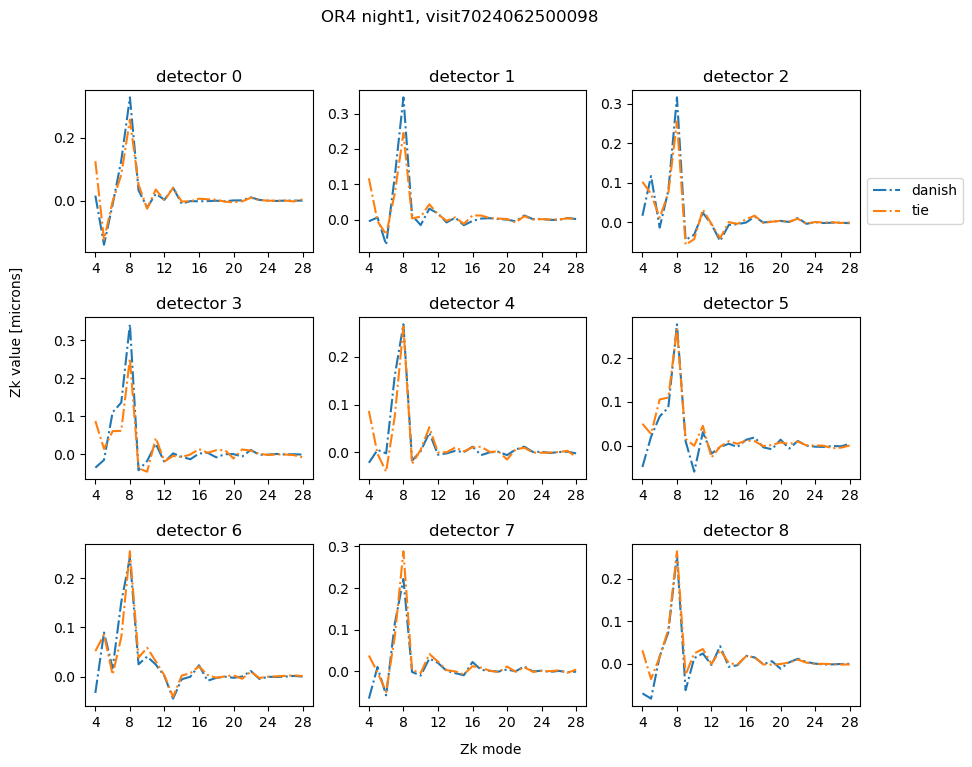

In [160]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for i in range(len(ax)):
    for method in results.keys():
        ax[i].plot(np.arange(4,29),results[method][visit][i][0], ls='-.', label=method)
        ax[i].set_title(f'detector {i}')
        ax[i].set_xticks(range(4,29,4))
ax[2].legend(bbox_to_anchor=[1.0,0.5])
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, visit{visit}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')

In [ ]:
Get the OPD for each mode: is the content of 

In [85]:
len(refs)

207

In [91]:
refs[0].dataId.detector.id

6

In [94]:
refs[0].dataId.detector.full_name

'R22_S20'

In [97]:
refs[0].dataId.visit.id

7024062500104

In [100]:
refs[0].dataId.day_obs.id

20240625

In [ ]:
ok, the raw data is in /sdf/data/rubin/repo/aos_imsim/raw/OR4/output/. Pull the OPD from there. There are files 


opd_20240625_000030.fits

and 


truth_CC_S_20240627_000077-0-i-R22_S02-002.txt.gz  



So for example for 